In [86]:
import os
import pydicom
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import scipy.linalg as la

In [42]:
from dipy.align.imwarp import SymmetricDiffeomorphicRegistration
from dipy.align.metrics import SSDMetric, CCMetric, EMMetric
import dipy.align.imwarp as imwarp
from dipy.viz import regtools

In [59]:
def get_slice(filename):
    'Reads from dicom file basic information and returns image as array + aquisition time'
    ds = pydicom.dcmread(filename)
    image_2d = ds.pixel_array.astype(float)
    return image_2d, np.float(ds.AcquisitionTime)

In [60]:
def get_t2(path, nr_slices = 29, time_steps = 7):
    '''
    Gets T2 weighted image and its acquisition times.
    IN:
        path - path with T2 weighted images
        nr_slices - nr of slices in image
        time_steps - nr of echo times per slice
    OUT:
        matrix - with T2 weighted images in numpy array (nr_slices, time_steps, width, heigth)
        time_lists - list of aquisition times
    '''
    slices = []
    time_slices = []
    for slice_idx in range(1, nr_slices+1): # iterates over all slices
        temp_slice = []
        time_slice = []
        for i in range(time_steps): # iterates over all time steps
            file_path = dirname + '%03d' % (i * nr_slices + slice_idx)
            image, aq_time = get_slice(file_path)
            temp_slice.append(image)
            time_slice.append(aq_time)
        temp_slice = np.array(temp_slice)
        time_slices.append(time_slice)
        slices.append(temp_slice)
    slices = np.array(slices)

    vmax = np.max(slices)
    # Rescaling grey scale between 0-255
    slices = (np.maximum(slices,0) / vmax) * 255.0
    slices = np.uint8(slices)
    return slices, time_slices

In [40]:
def registration_between_timesteps(image_matrix):
    '''
    Performs registration between each 2 time points of an image slice.
    IN:
        image_matrix - matrix with T2 weighted images (slices, time steps, width, heigth)
    OUT:
        image_reg_matrix - matrix of the same size as image_matrix
    '''
    metric = CCMetric(2)
    level_iters = [200, 100, 50, 25]
    sdr = SymmetricDiffeomorphicRegistration(metric, level_iters, inv_iter = 50)
    
    image_reg_matrix = np.zeros(image_matrix.shape)
    
    for i_sl in range(image_matrix.shape[0]):
        image_reg_matrix[i_sl, 0, :, :] = image_matrix[i_sl, 0, :, :]
        for i_t in range(image_matrix.shape[1]-1):
            mapping = sdr.optimize(image_matrix[i_sl, i_t, :, :], image_matrix[i_sl, i_t+1, :, :])
            image_reg_matrix[i_sl, i_t+1, :, :] = mapping.transform(image_matrix[i_sl, i_t+1, :, :])
    return image_reg_matrix

In [29]:
dirname = "data/9003126/T2/"

In [61]:
t2imgs, t2times = get_t2(dirname)

In [52]:
#t2imgs_reg = registration_between_timesteps(t2imgs)
#np.save('registered.npy', t2imgs_reg)
t2imgs_reg = np.load('registered.npy')

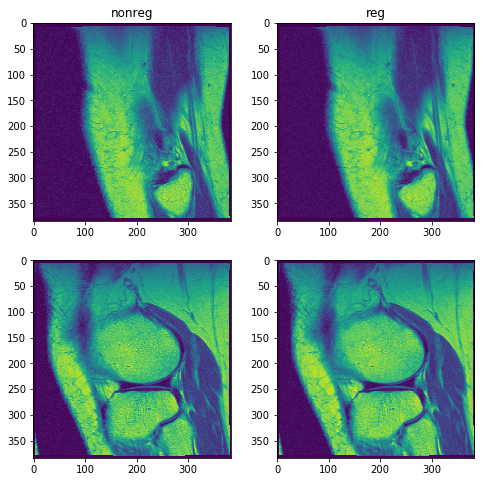

In [213]:
plt.figure(figsize=(8,8))
plt.subplot(221)
plt.imshow(t2imgs[1,5,:,:])
plt.title('nonreg')
plt.subplot(222)
plt.imshow(t2imgs_reg[1,5,:,:])
plt.title('reg')
plt.subplot(223)
plt.imshow(t2imgs[5,3,:,:])
plt.subplot(224)
plt.imshow(t2imgs_reg[5,3,:,:])


In [214]:
scan = t2imgs_reg[1,:,:,:]
time = np.array(t2times[1])

In [215]:
data = np.log(scan + 0.00000000001) # to avoid log(0)
x = np.concatenate((np.ones_like(time[..., np.newaxis]), -time[..., np.newaxis]), 1)

In [216]:
t2_matrix = np.zeros((data.shape[1], data.shape[2]))
exps = []
for ix in range(data.shape[2]):
    for iy in range(data.shape[2]):
        if all(data[:,ix,iy] == data[0,ix,iy]): # if constant value, decay 0 
            t2_matrix[ix, iy] = 0
            continue
        beta, _, _, _ = la.lstsq(x, data[:,ix,iy])
        exps.append(data[:,ix,iy])
        s0_ = np.exp(beta[0])
        t2_ = 1/beta[1]
        t2_matrix[ix, iy] = t2_

In [217]:
t2_matrix[np.where(t2_matrix>np.percentile(t2_matrix.flatten(), 98.))]=0
t2_matrix[np.where(t2_matrix<np.percentile(t2_matrix.flatten(), 2.))]=0

In [218]:
t2_matrix.min()

-0.60073624453928509

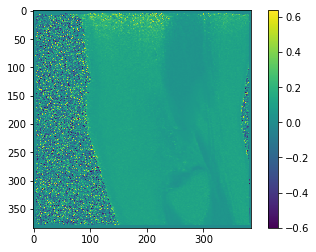

In [219]:
plt.imshow(t2_matrix)
plt.colorbar()

In [220]:
exps = np.array(exps)

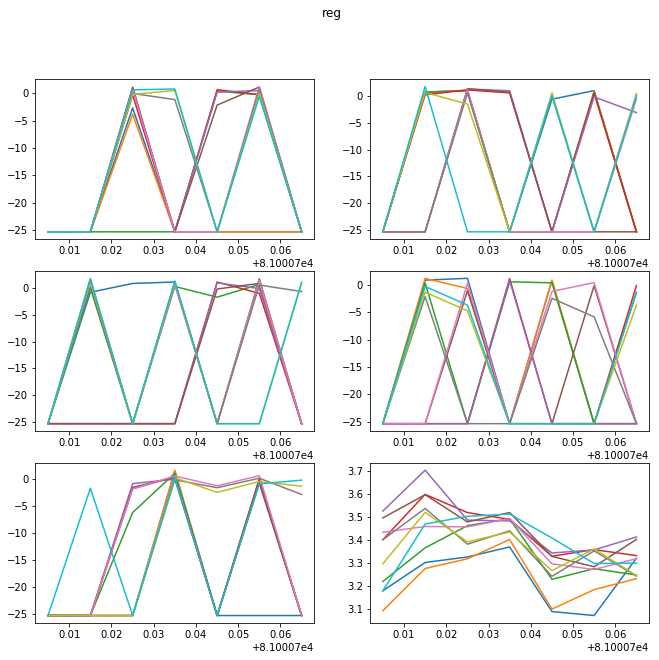

In [221]:
plt.figure(figsize=(11,10))
plt.subplot(3,2,1)
plt.plot(time, exps[:10].T,'-')
plt.subplot(3,2,2)
plt.plot(time, exps[20:30].T,'-')
plt.subplot(3,2,3)
plt.plot(time, exps[90:100].T,'-')
plt.subplot(3,2,4)
plt.plot(time, exps[250:260].T,'-')
plt.subplot(3,2,5)
plt.plot(time, exps[300:310].T,'-')
plt.subplot(3,2,6)
plt.plot(time, exps[450:460].T,'-')
plt.suptitle('reg')